In [1]:
import os
from nilearn import datasets, plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Headers of the dataframe: 
 Subject ID, Sex, Research Group, Age, Modality, Description 

First 5 rows of the dataframe: 
    Subject ID Sex Research Group   Age Modality         Description
0  002_S_0295   M             CN  90.0     fMRI  Resting State fMRI
1  002_S_0413   F             CN  81.5     fMRI  Resting State fMRI
2  002_S_0685   F             CN  94.7     fMRI  Resting State fMRI
3  002_S_0729   F            MCI  70.3     fMRI  Resting State fMRI
4  002_S_1155   M            MCI  63.0     fMRI  Resting State fMRI 

The shape of the dataframe: 
 (197, 6) 

The number of patients: 
 197 

Distribution of the diagnostic label: 
 Research Group
EMCI    54
CN      47
LMCI    34
AD      31
SMC     25
MCI      6
Name: count, dtype: int64 



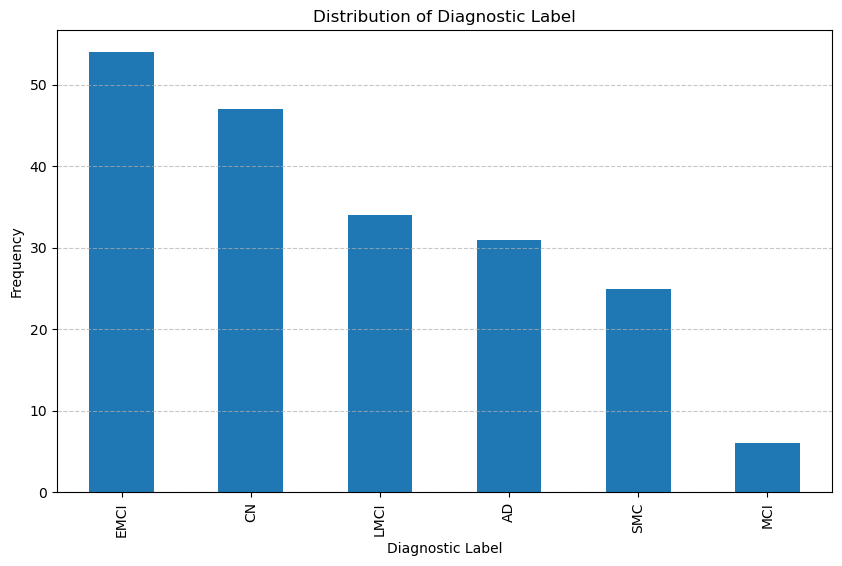

Distribution of the age of the patients (rounded): 
 Age
56.0     2
57.0     2
58.0     1
59.0     1
60.0     3
61.0     4
62.0     2
63.0     4
64.0     4
65.0     3
66.0     7
67.0     7
68.0    10
69.0    11
70.0    11
71.0     8
72.0    13
73.0     9
74.0    18
75.0    13
76.0     8
77.0     9
78.0     6
79.0    11
80.0     7
81.0     3
82.0     3
83.0     2
84.0     1
85.0     4
86.0     2
87.0     4
88.0     1
89.0     1
90.0     1
95.0     1
Name: count, dtype: int64 



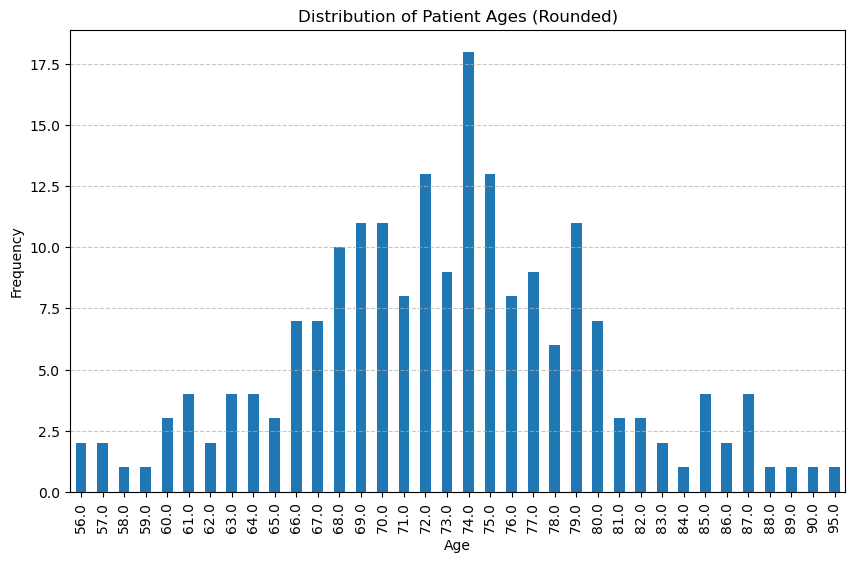

Distribution of the sex of the patients: 
 Sex
F    104
M     93
Name: count, dtype: int64 



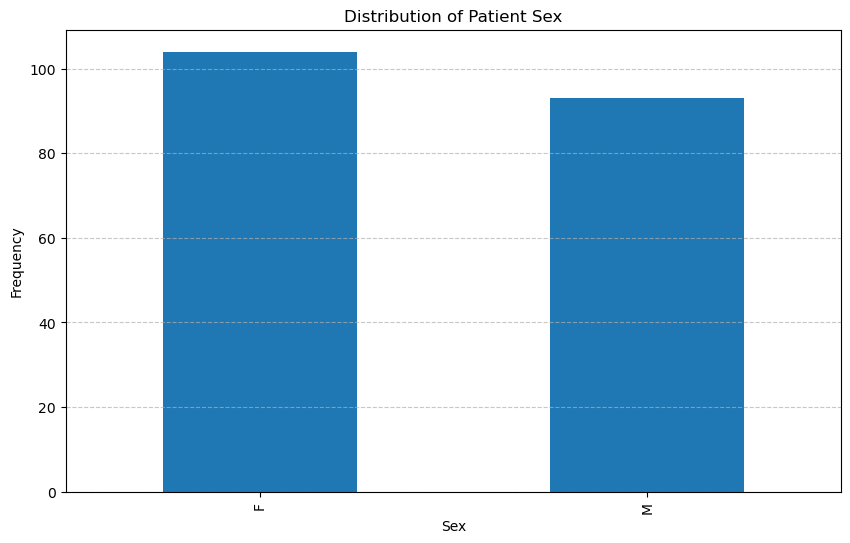

In [2]:
patient_info = pd.read_csv('ADNI_full/patient_info.csv')

# Visualizing a few features of the dataframe
print(f'Headers of the dataframe: \n', ', '.join(patient_info.columns), '\n')
print(f'First 5 rows of the dataframe: \n', patient_info.head(), '\n')
print(f'The shape of the dataframe: \n', patient_info.shape, '\n')
print(f'The number of patients: \n', patient_info['Subject ID'].nunique(), '\n')

# Visualizing the distribution of a few features in the dataframe
## Distribution of the diagnostic label
print(f'Distribution of the diagnostic label: \n', patient_info['Research Group'].value_counts(), '\n')
plt.figure(figsize=(10, 6))
patient_info['Research Group'].value_counts().plot(kind='bar')
plt.title("Distribution of Diagnostic Label")
plt.xlabel("Diagnostic Label")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
## Distribution of the age of the patients
rounded_age_distribution = patient_info['Age'].round().value_counts().sort_index()
print(f'Distribution of the age of the patients (rounded): \n', rounded_age_distribution, '\n')
plt.figure(figsize=(10, 6))
rounded_age_distribution.plot(kind='bar')
plt.title("Distribution of Patient Ages (Rounded)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
## Distribution of the sex of the patients
print(f'Distribution of the sex of the patients: \n', patient_info['Sex'].value_counts(), '\n')
plt.figure(figsize=(10, 6))
patient_info['Sex'].value_counts().plot(kind='bar')
plt.title("Distribution of Patient Sex")
plt.xlabel("Sex")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [3]:
# Creating the diagnostic_label.csv, age.csv and sex.csv files from the patient_info.csv file
def extract_info_and_write_csv(patient_info_file):
    patient_info_df = pd.read_csv(patient_info_file)

    age_df = patient_info_df[['Age']]
    age_df.to_csv('ADNI_full/age.csv', index=False, header=False)

    sex_df = patient_info_df[['Sex']]
    sex_df.to_csv('ADNI_full/sex.csv', index=False, header=False)

    diagnostic_label_df = patient_info_df[['Research Group']]
    diagnostic_label_df.to_csv('ADNI_full/diagnostic_label.csv', index=False, header=False)

extract_info_and_write_csv('ADNI_full/patient_info.csv')

In [4]:
# Generating the brain atlas
def gen_atlas_labels():
    atlas = datasets.fetch_atlas_aal()
    atlas_filename = atlas.maps
    atlas_labels = atlas.labels
    n_ROIS = len(atlas_labels)
    return atlas, atlas_labels, atlas_filename, n_ROIS

atlas, atlas_filename, labels, n_ROIS = gen_atlas_labels()

# Finding the coordinates of the brain segments
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)

# Making a dictionary out of the positions of the brain segments and the positions in MNI space
brain_segments_pos = {}
for idx, val in enumerate(atlas.labels):
    brain_segments_pos[val] = list(np.around(coordinates[idx],2))

In [5]:
# Here I start with the ADNI_full folder with the time_series folder already generated, so I only need to load the time series
def load_time_series():
    root = 'ADNI_full/time_series'
    time_series_list = os.listdir(root)
    time_series=[]
    for i in time_series_list:
        time_series_sub = np.loadtxt(os.path.join(root, i), delimiter=',')
        time_series.append(time_series_sub)
    return time_series

In [6]:
time_series_list = load_time_series()
# time_series_list[0].shape
time_series_list[0]

array([[ 0.2642692 ,  0.16040181,  0.57371396, ...,  0.12500933,
         0.10330407,  0.87038028],
       [ 0.19085962,  0.2113862 , -0.33421484, ..., -0.578403  ,
        -0.93550503, -2.03994942],
       [ 0.72830963,  0.59393024,  0.08317391, ..., -1.05355597,
        -1.09166551, -2.44226503],
       ...,
       [-0.55627531, -0.6736297 ,  0.30549684, ..., -0.31409562,
         0.13894109,  1.10015774],
       [-0.0594647 , -0.80384517,  0.75589734, ...,  0.27089831,
         0.33234671,  1.13989151],
       [ 0.09926764,  0.10549345,  0.25314325, ..., -0.04953214,
        -0.06472567,  0.06441833]])

In [7]:
# Make the list of time series into a list of df
def list_of_df_of_time_series(time_series_list):
    time_series_df_list = []
    for ts in time_series_list:
        df = pd.DataFrame(ts)
        time_series_df_list.append(df)
    return time_series_df_list

In [8]:
time_series_df_list = list_of_df_of_time_series(time_series_list)
time_series_df_list[0]

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,0.264269,0.160402,0.573714,-0.016659,0.147470,0.327784,0.563114,-0.070485,-0.120396,0.258554,...,0.957419,1.334523,1.962177,0.217791,-0.462089,-0.964584,0.139684,0.125009,0.103304,0.870380
1,0.190860,0.211386,-0.334215,0.574008,-0.535597,-0.334685,0.021171,-0.062069,-0.619519,-0.417604,...,-1.813221,-0.202942,-3.085048,-0.824117,0.126268,0.982404,-0.056039,-0.578403,-0.935505,-2.039949
2,0.728310,0.593930,0.083174,0.961234,-0.744761,-0.343953,0.225210,0.192818,-0.765734,-0.846390,...,-2.118421,-1.320937,-3.443132,-0.496449,0.048864,1.031379,-0.622402,-1.053556,-1.091666,-2.442265
3,1.173054,0.813959,0.850006,0.986218,-0.296675,-0.042714,0.487224,0.657435,-0.623107,-0.809165,...,-0.356367,-1.495009,-0.637532,0.484914,-0.155445,0.063728,-0.694769,-0.650007,-0.214159,-0.715906
4,0.520118,0.189850,0.294528,0.572696,0.235907,-0.238069,-0.158185,0.916665,-0.472160,-0.386730,...,1.051838,-0.867597,0.830351,0.510131,0.291727,0.084524,0.454218,0.673080,0.886583,0.653972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,-1.887287,-0.764243,-2.184397,-0.703209,-0.268133,0.508347,-1.634119,-0.079656,0.088563,-0.193855,...,-0.806249,-1.130631,1.380863,2.626379,1.571630,1.059438,0.094542,-0.402776,-0.310997,0.092674
135,-1.408172,-0.359410,-1.143153,0.383183,0.688927,0.152477,-0.765884,0.836259,1.406583,0.973454,...,-1.051386,-1.318953,-0.254829,-0.240125,-0.179914,-0.150726,-1.168134,-0.838199,-0.244921,0.450691
136,-0.556275,-0.673630,0.305497,0.371132,1.935064,0.062150,0.366279,0.592698,2.608838,1.816980,...,-0.127304,0.130361,-1.071571,-2.299211,-1.188028,-0.992597,-1.128509,-0.314096,0.138941,1.100158
137,-0.059465,-0.803845,0.755897,0.056427,1.975473,0.260254,0.696158,0.131610,2.123145,1.474213,...,0.605091,1.033485,-0.620795,-1.921884,-0.981408,-0.837469,-0.304420,0.270898,0.332347,1.139892


In [9]:
# Defining the different correlation relations to build the correlation matrix.
# We also set the NaN values to 0.

def pearson_corr(time_series_df_list):
    corr_matrices = []
    for df in time_series_df_list:
        corr_df = df.corr(method='pearson').fillna(0)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def spearman_rank_corr(time_series_df_list):
    corr_matrices = []
    for df in time_series_df_list:
        corr_df = df.corr(method='spearman').fillna(0)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def kendall_rank_corr(time_series_df_list):
    corr_matrices = []
    for df in time_series_df_list:
        corr_df = df.corr(method='kendall').fillna(0)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def partial_corr(time_series_df_list):
    corr_matrices = []
    for df in time_series_df_list:
        corr_df = df.corr(method='pearson').fillna(0)
        n = corr_df.shape[0]
        partial_corr_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                partial_corr_matrix[i, j] = -corr_df.iloc[i, j] / np.sqrt(corr_df.iloc[i, i] * corr_df.iloc[j, j])
        corr_matrices.append(partial_corr_matrix)
    return corr_matrices

In [10]:
# Plot the correlation matrix
def plot_corr(corr_matrix, method):
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(f'{method} Correlation Matrix')
    plt.show()

In [11]:
# Loading the list of time_series and building the list of df of time_series
time_series_list = load_time_series()
time_series_df_list = list_of_df_of_time_series(time_series_list)

In [12]:
pd.read_csv('ADNI_full/time_series/ts_136_S_4993.csv', header=None)

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,-1.190398,-0.972963,0.226812,0.280725,0.528322,0.699922,-0.176255,0.039089,0.362092,0.092805,...,0.688283,0.197731,1.244753,-0.037378,0.080815,-0.267659,-1.000753,-0.856691,-0.708275,-0.878461
1,0.818726,0.677477,0.109644,-1.150801,-0.296411,-0.157806,0.462802,0.023956,0.338292,0.132282,...,-0.070588,0.186056,-0.145575,-0.313785,-0.690359,-1.061847,-0.295983,-0.260207,-0.668422,-0.200777
2,1.038684,0.761095,0.215967,-1.448907,-0.529243,-0.542884,0.494963,-0.319669,0.076373,0.351783,...,-0.958941,-0.509783,-0.905100,-0.266104,-0.314978,-1.023834,0.131103,0.056500,-0.543381,-0.067524
3,0.075755,-0.269712,0.127216,-0.508260,-0.530693,-0.495079,0.256457,-0.508991,-0.499172,0.602297,...,-1.606205,-1.292210,-1.045998,0.068893,0.632727,-0.172084,0.082335,-0.148194,-0.468041,-0.462297
4,-0.309977,-0.868512,-0.472827,0.673015,-0.694809,-0.240307,0.278718,-0.055018,-0.908781,0.629257,...,-1.692743,-1.306159,-0.909895,0.473145,0.839391,0.786044,-0.312122,-0.584935,-0.438843,-0.754571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,0.363390,0.432649,-1.109584,-0.329122,-0.953375,0.110484,-0.544625,0.177013,-0.099619,0.439159,...,-0.716568,-0.926259,-0.577814,0.398651,-0.326430,0.235024,0.321004,0.659647,0.963812,1.146606
135,0.650736,0.786951,-0.637519,0.255729,-1.347358,-1.284529,0.761300,0.643617,-1.037942,-1.220383,...,-0.585604,-0.777869,-0.519262,0.190539,0.818616,1.454174,0.666566,0.513315,0.413306,0.523821
136,0.741008,1.264224,0.301536,0.615906,-0.416866,-1.723537,1.255553,0.299090,-1.074755,-1.926200,...,-0.103415,0.135583,0.024489,0.202809,1.912377,2.719573,1.115819,0.279943,-0.025997,-0.370245
137,0.411444,0.943533,0.693983,0.550800,0.275428,-1.114997,0.923061,-0.038980,-0.653500,-1.387144,...,0.231867,0.564941,0.330979,0.079514,1.625550,2.189395,0.827734,0.024221,-0.233768,-0.742139


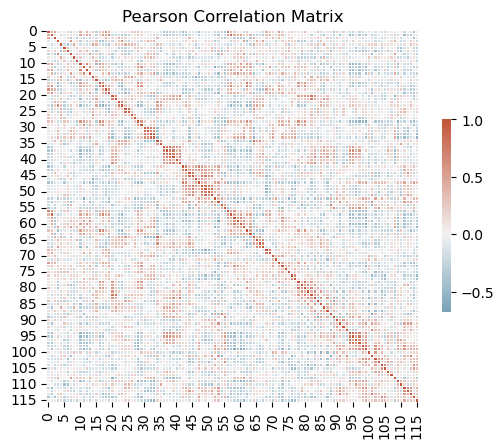

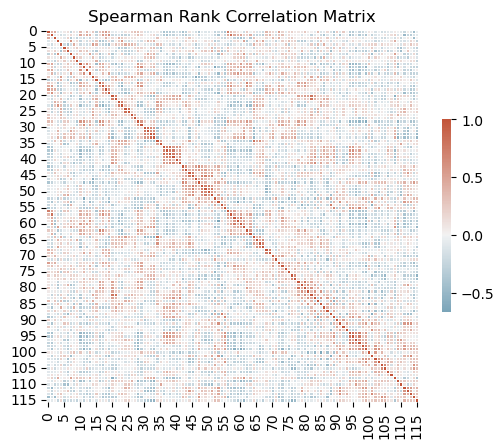

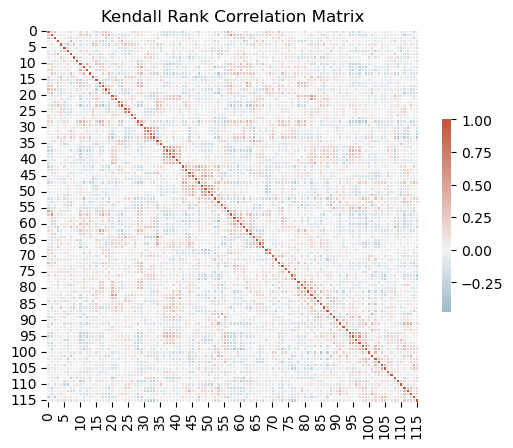

/var/folders/wh/snjqmpvj7qv64q1ngy8zvqbh0000gn/T/ipykernel_29378/2365166672.py:33: RuntimeWarning: invalid value encountered in scalar divide
  partial_corr_matrix[i, j] = -corr_df.iloc[i, j] / np.sqrt(corr_df.iloc[i, i] * corr_df.iloc[j, j])


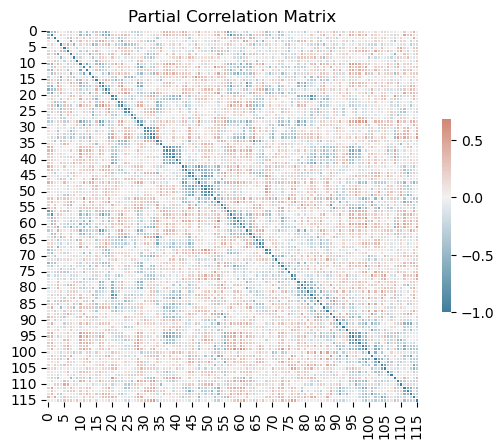

In [13]:
# Generating the correlation matrices
idx_patient = 20

# Using the pearson correlation function
corr_matrix_pearson = pearson_corr(time_series_df_list)
plot_corr(corr_matrix_pearson[idx_patient], 'Pearson')

# Using the spearman rank correlation function
corr_matrix_spearman = spearman_rank_corr(time_series_df_list)
plot_corr(corr_matrix_spearman[idx_patient], 'Spearman Rank')

# Using the kendall rank correlation function
corr_matrix_kendall = kendall_rank_corr(time_series_df_list)
plot_corr(corr_matrix_kendall[idx_patient], 'Kendall Rank')

# Using the partial correlation function
corr_matrix_partial = partial_corr(time_series_df_list)
plot_corr(corr_matrix_partial[idx_patient], 'Partial')

In [14]:
# Compare the differences between all the matrices. Here I am using the Frobenius norm to measure the element-wise differences.

matrices = [corr_matrix_pearson[idx_patient], corr_matrix_spearman[idx_patient], corr_matrix_kendall[idx_patient], corr_matrix_partial[idx_patient]]

def compare_correlation_matrices(matrices):
    num_matrices = len(matrices)
    dissimilarities = np.zeros((num_matrices, num_matrices))
    for i in range(num_matrices):
        for j in range(i+1, num_matrices):
            diff_matrix = matrices[i] - matrices[j]
            frobenius_norm = np.linalg.norm(diff_matrix, ord='fro')
            dissimilarities[i, j] = frobenius_norm
            dissimilarities[j, i] = frobenius_norm
    return dissimilarities

# Compare matrices
dissimilarities = compare_correlation_matrices(matrices)
print("Dissimilarities between correlation matrices:")
print(dissimilarities)

Dissimilarities between correlation matrices:
[[ 0.          4.0157538   9.97899635 59.66027668]
 [ 4.0157538   0.          8.3128964  58.44870101]
 [ 9.97899635  8.3128964   0.         50.87390177]
 [59.66027668 58.44870101 50.87390177  0.        ]]


In [15]:
# Saving all the Correlation Matrices
def save_matrix(corr_matrix, method):
    directory = f'ADNI_full/corr_matrices/corr_matrix_{method}/'
    patient_info = pd.read_csv('ADNI_full/patient_info.csv')
    os.makedirs(directory, exist_ok=True)
    for idx_patient, name_patient in enumerate(patient_info['Subject ID'].values):
        np.savetxt(f'{directory}patient_{name_patient}.csv', corr_matrix[idx_patient], delimiter=',')
    return None

save_matrix(corr_matrix_pearson, 'pearson')
save_matrix(corr_matrix_spearman, 'spearman')
save_matrix(corr_matrix_kendall, 'kendall')
save_matrix(corr_matrix_partial, 'partial')

Faire un dictionnaire au lieu d'un pd data frame et le sauver en pkl au lieu de csv

In [16]:
# # Creating the dataframe with the time series, the correlation matrices and the diagnostic label for each patient
# def create_df(time_series, corr_matrix_methods_list, corr_matrix_methods_names, patient_info):
#     df = pd.DataFrame()
#     df['Patient_id'] = patient_info['Subject ID']
#     df['Age'] = patient_info['Age']
#     df['Sex'] = patient_info['Sex']
#     df['Time_series'] = time_series
#     for i in range(len(corr_matrix_methods_list)):
#         corr_matrix = corr_matrix_methods_list[i]
#         method = corr_matrix_methods_names[i]
#         df[f'Corr_matrix_{method}'] = corr_matrix
#     df['Diagnostic_label'] = patient_info['Research Group']

#     # Saving the DataFrame to a CSV file
#     df.to_csv('ADNI_full/full_df.csv', index=False)

#     return df

# # Loading the diagnostic label
# patient_info = pd.read_csv('ADNI_full/patient_info.csv')
# corr_matrix_methods_list = [corr_matrix_pearson, corr_matrix_spearman , corr_matrix_kendall, corr_matrix_partial]
# corr_matrix_methods_names = ['pearson', 'spearman', 'kendall', 'partial']
# full_df = create_df(df_time_series, corr_matrix_methods_list, corr_matrix_methods_names, patient_info)


In [23]:
# Creating a dictionnary with the time series, the correlation matrices and the diagnostic label for each patient
def create_dict(patient_info, corr_matrices):
    full_data_dict = {}
    for i, patient_id in enumerate(patient_info['Subject ID'].values):
        age = patient_info.loc[patient_info['Subject ID'] == patient_id, 'Age'].values[0]
        sex = patient_info.loc[patient_info['Subject ID'] == patient_id, 'Sex'].values[0]
        diagnostic_label = patient_info.loc[patient_info['Subject ID'] == patient_id, 'Research Group'].values[0]
        patient_data = [age, sex, diagnostic_label] + corr_matrices
        full_data_dict[patient_id] = patient_data
    return full_data_dict

corr_matrices = [corr_matrix_pearson, corr_matrix_spearman , corr_matrix_kendall, corr_matrix_partial]
full_data_dict = create_dict(patient_info, corr_matrices)
# Saving the dictionary to a pickle file
with open('ADNI_full/full_data_dict.pkl', 'wb') as f:
    pkl.dump(full_data_dict, f)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


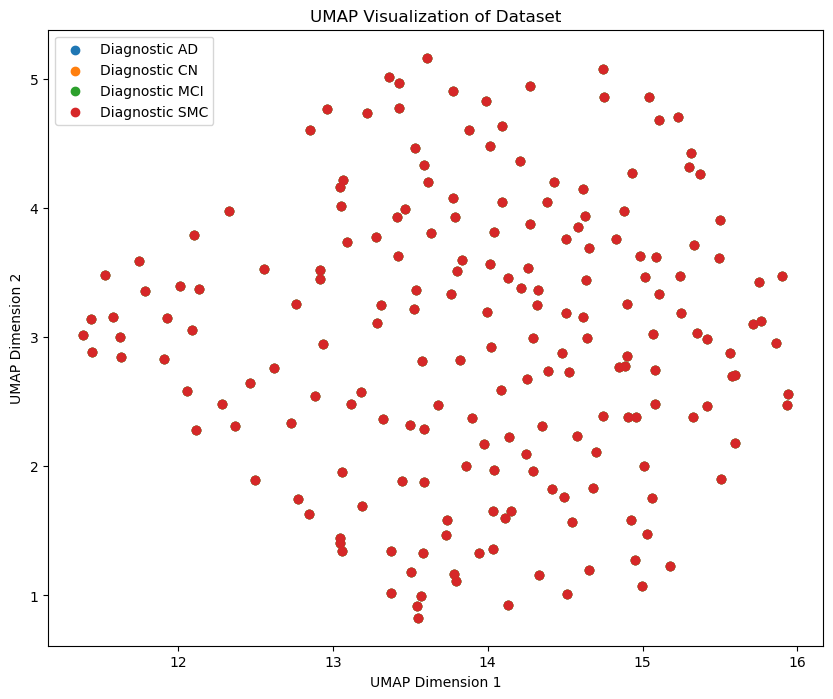

In [35]:
# Exploring Umap to visualize the similarity between the MCI and SMC patients
## Code taken/inspired from: https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import umap

def prepare_data(full_data_dict):
    # Extracting features from the dictionary
    features = []
    labels = []
    for i, data in enumerate(full_data_dict.values()):
        diagnostic_label = data[2]
        cm_pearson = data[3][i]
        # print(len(cm_pearson))
        # print(cm_pearson)
        upper_triangle = np.triu_indices(len(cm_pearson), k=1)
        features.append(cm_pearson[upper_triangle])
        diagnostic_label = 'MCI' if diagnostic_label in ['LMCI', 'EMCI', 'MCI'] else diagnostic_label
        labels.append(diagnostic_label)
    return np.array(features), np.array(labels)

# Prepare data
features, labels = prepare_data(full_data_dict)

# umap_model = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean')
umap_model = umap.UMAP()
embedding = umap_model.fit_transform(features)

plt.figure(figsize=(10, 8))
for label in np.unique(labels):
plt.scatter(embedding[labels == label, 0], embedding[labels == label, 1], label=f'Diagnostic {label}')
plt.title('UMAP Visualization of Dataset')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()


In [ ]:
# Grouping LMCI, EMCI, and MCI patients together
full_df['Diagnostic_label'] = full_df['Diagnostic_label'].map(lambda x: 'MCI' if x in ['LMCI', 'EMCI', 'MCI'] else x)

# Comparing all the diagnostic labels (not wrt time series)

mci_data = full_df[full_df['Diagnostic_label'] == 'MCI']
smc_data = full_df[full_df['Diagnostic_label'] == 'SMC']
ad_data = full_df[full_df['Diagnostic_label'] == 'AD']
cn_data = full_df[full_df['Diagnostic_label'] == 'CN']

# Convert to numpy array and stack
mci_data_stacked = np.vstack(mci_data)
smc_data_stacked = np.vstack(smc_data)
ad_data_stacked = np.vstack(ad_data)
cn_data_stacked = np.vstack(cn_data)

# Concatenate data for all diagnostic labels
all_data = np.vstack((mci_data_stacked, smc_data_stacked, ad_data_stacked, cn_data_stacked))

# # Standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(all_data)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_data)

# Plot the UMAP embedding
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=["MCI"] * len(mci_data_stacked) + ["SMC"] * len(smc_data_stacked) +
        ["AD"] * len(ad_data_stacked) + ["CN"] * len(cn_data_stacked),
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.8
)

plt.title('UMAP Visualization of Diagnostic Groups', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Diagnostic Label', fontsize=12)
plt.show()



ValueError: could not convert string to float: 'Patient_id'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/wh/snjqmpvj7qv64q1ngy8zvqbh0000gn/T/ipykernel_17096/1079020316.py:23: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


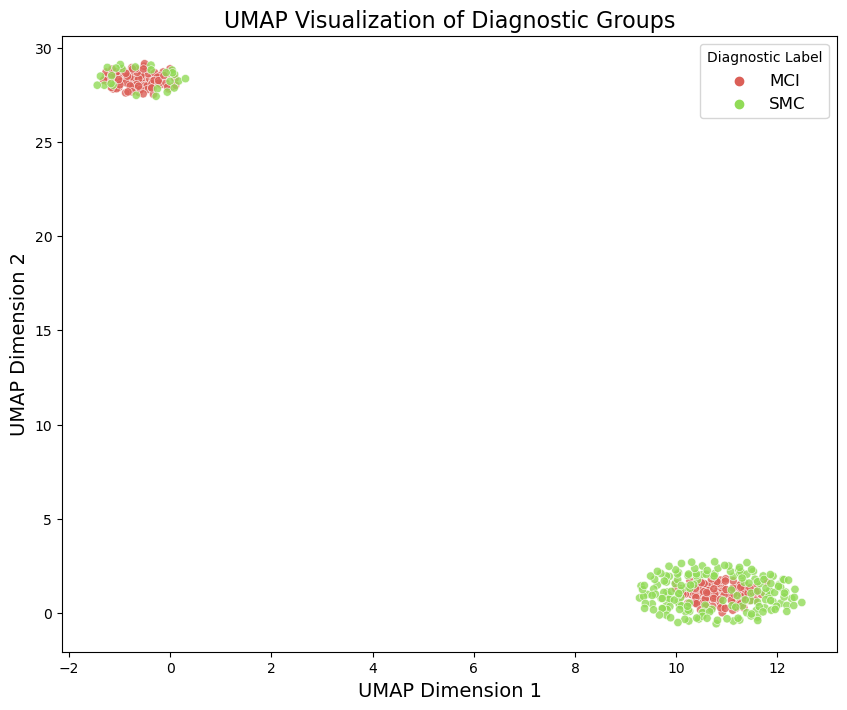

In [ ]:
# Comparing only the MCI and SMC patients (not wrt time series)

mci_data = full_df['Diagnostic_label'] == 'MCI'
smc_data = full_df['Diagnostic_label'] == 'SMC'

# Convert to numpy array and stack
mci_data_stacked = np.vstack(mci_data)
smc_data_stacked = np.vstack(smc_data)

# Concatenate data for all diagnostic labels
all_data = np.vstack((mci_data_stacked, smc_data_stacked))

# # Standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(all_data)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_data)

# Plot the UMAP embedding
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=["MCI"] * len(mci_data_stacked) + ["SMC"] * len(smc_data_stacked),
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.8
)
plt.title('UMAP Visualization of Diagnostic Groups', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Diagnostic Label', fontsize=12)
plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/wh/snjqmpvj7qv64q1ngy8zvqbh0000gn/T/ipykernel_17096/1174276229.py:28: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


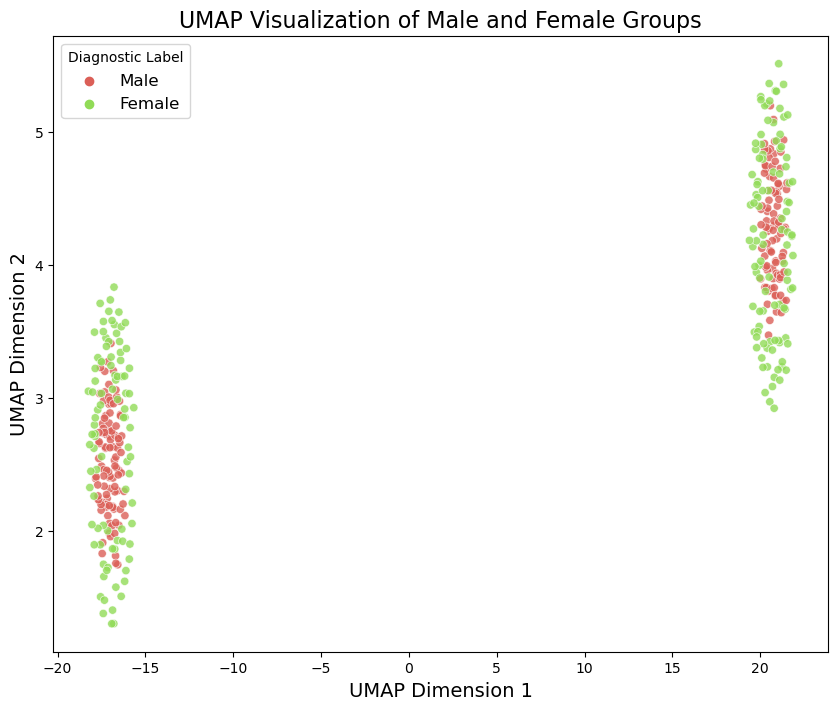

In [ ]:
# Exploring Umap to visualize the similarity between the Male and Female patients
## Code taken/inspired from: https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import umap
from sklearn.preprocessing import StandardScaler

# Comparing all the diagnostic labels (not wrt time series)

male_data = full_df['Sex'] == 'M'
female_data = full_df['Sex'] == 'F'

# Convert to numpy array and stack
male_data_stacked = np.vstack(male_data)
female_data_stacked = np.vstack(female_data)

# Concatenate data for all diagnostic labels
all_data = np.vstack((male_data_stacked, female_data_stacked))

# # Standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(all_data)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_data)

# Plot the UMAP embedding
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=["Male"] * len(male_data_stacked) + ["Female"] * len(female_data_stacked),
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.8
)

plt.title('UMAP Visualization of Male and Female Groups', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Diagnostic Label', fontsize=12)
plt.show()



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


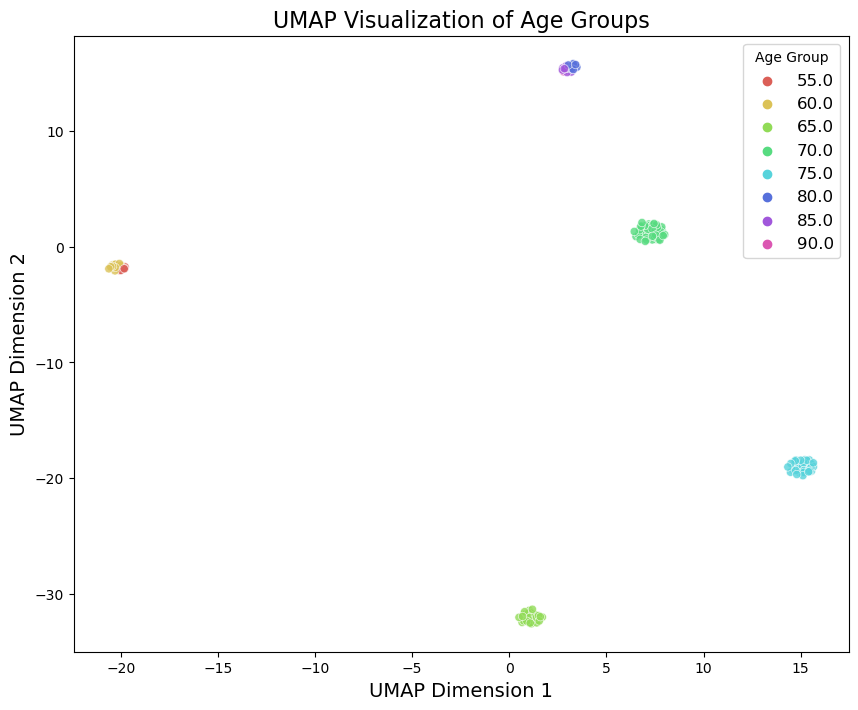

In [ ]:
# Function to group ages into 5-year intervals
def group_age(age):
    return (age // 5) * 5

# Applying the function to create age groups
full_df['Age_Group'] = full_df['Age'].apply(group_age)

# Extracting age group data
age_group_data = full_df['Age_Group']

# Convert to numpy array
age_group_data_stacked = np.vstack(age_group_data)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(age_group_data_stacked)

# Plot the UMAP embedding
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=age_group_data,
    palette=sns.color_palette("hls", len(age_group_data.unique())),
    legend="full",
    alpha=0.8
)

plt.title('UMAP Visualization of Age Groups', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Age Group', fontsize=12)
plt.show()

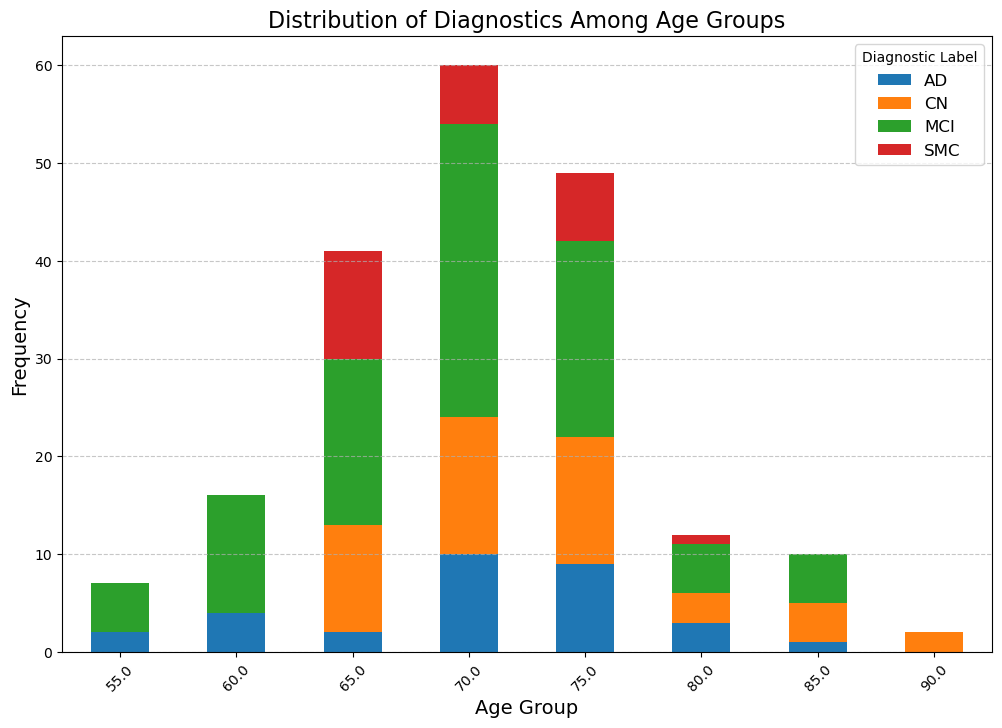

In [ ]:
# Function to group ages into 5-year intervals
def group_age(age):
    return (age // 5) * 5

# Applying the function to create age groups
full_df['Age_Group'] = full_df['Age'].apply(group_age)

# Grouping LMCI, EMCI, and MCI patients together
full_df['Diagnostic_label'] = full_df['Diagnostic_label'].map(lambda x: 'MCI' if x in ['LMCI', 'EMCI', 'MCI'] else x)

# Pivot the data
pivot_df = full_df.pivot_table(index='Age_Group', columns='Diagnostic_label', aggfunc='size', fill_value=0)

# Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribution of Diagnostics Among Age Groups', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Diagnostic Label', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
